In [3]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

In [7]:
query = {
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:BNL-ATLAS AND dst:*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1468533600000,
                  "lte": 1468792800000,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "1h",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": 1468533600000,
          "max": 1468792800000
        }
      },
      "aggs": {
        "7": {
          "avg": {
            "field": "done-total-1h"
          }
        },
        "8": {
          "avg": {
            "field": "queued-total"
          }
        }
      }
    }
  }
}

In [10]:
def convNone(data):
    data = np.array(data,dtype=np.float)
    return data
    
queuedResponse = es.search(index="atlas_ddm-metrics*", body=query, request_timeout=600) 

avgDoneData = []
avgQueuedData = []
timestamp = []


for r in queuedResponse['aggregations']['2']['buckets']:
    #Get field value and timestamp
    avgDoneData.append(r['7']['value'])
    avgQueuedData.append(r['8']['value'])
    timestamp.append(r['key'])
    

## remove value/key pairs that are empty  ##      
avgQueuedData = convNone(avgQueuedData)
avgDoneData = convNone(avgDoneData)
timestamp =  convNone(timestamp) 

indices = np.logical_not(np.isnan(avgQueuedData))

avgDoneData = avgDoneData[indices]
avgQueuedData = avgQueuedData[indices]
timestamp = timestamp[indices]

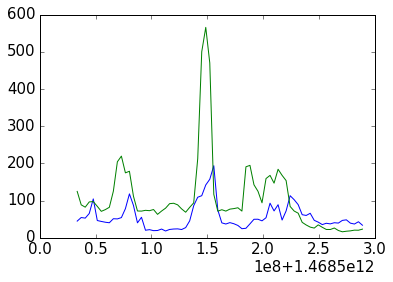

In [12]:
plt.plot(timestamp,avgDoneData)
plt.plot(timestamp,avgQueuedData)

In [30]:
from scipy.optimize import curve_fit

def func(x,a):
    return a*(x)

x = avgQueuedData
y = avgDoneData

popt,pcov = curve_fit(func,x,y)

In [31]:
popt

array([ 0.37255998])

In [32]:
pcov

array([[ 0.00089546]])

In [35]:
modeledDoneData = popt[0]*(avgQueuedData)

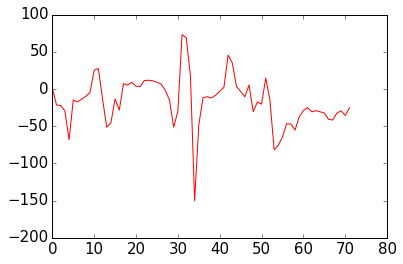

In [38]:
plt.plot(modeledDoneData-avgDoneData,'r')


In [37]:
np.corrcoef(modeledDoneData,avgDoneData)

array([[ 1.        ,  0.56949953],
       [ 0.56949953,  1.        ]])